# Deep Learning With PyTorch 16 - TensorBoard

Use the code from tutorial 13

epoch 1 / 2, step 100/600, loss = 0.2550
epoch 1 / 2, step 200/600, loss = 0.0666
epoch 1 / 2, step 300/600, loss = 0.0822
epoch 1 / 2, step 400/600, loss = 0.1541
epoch 1 / 2, step 500/600, loss = 0.0756
epoch 1 / 2, step 600/600, loss = 0.1213
epoch 2 / 2, step 100/600, loss = 0.1114
epoch 2 / 2, step 200/600, loss = 0.2732
epoch 2 / 2, step 300/600, loss = 0.0565
epoch 2 / 2, step 400/600, loss = 0.1122
epoch 2 / 2, step 500/600, loss = 0.0733
epoch 2 / 2, step 600/600, loss = 0.1459
Accuracy of the network on the 10000 test images: 96.85 %


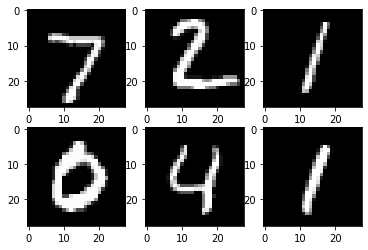

In [23]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
writer = SummaryWriter("runs/mnist")

# device config
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
# hyper parameters
input_size = 784 # 28x28
hidden_size = 100
num_classes = 10

num_epochs = 2
batch_size = 100
learning_rate = 0.01

# MNIST
train_dataset = torchvision.datasets.MNIST(root="./data/", train=True, download=False,
                                             transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root="./data/", train=False, download=False,
                                             transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                           shuffle=False)

examples = iter(test_loader)
example_data, example_targets = examples.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('mnist_images', img_grid)

class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out
    
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
writer.add_graph(model, samples.reshape(-1, 28*28))
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1, 28, 28
        # 100, 784
        # put -1 in first dimension so pytorch will figure it out for us
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        running_correct += (predictions == labels).sum().item()
        
        if (i+1) % 100 == 0:
            print(f"epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}")
            writer.add_scalar("training loss", running_loss/100, epoch * n_total_steps + i)
            writer.add_scalar("accuracy", running_correct/100, epoch * n_total_steps + i)
            running_loss = 0.0
            running_correct = 0
class_labels = []
class_preds = []
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        values, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        class_probs_batch = [F.softmax(output, dim=0) for output in outputs]

        class_preds.append(class_probs_batch)
        class_labels.append(predicted)

    class_preds = torch.cat([torch.stack(batch) for batch in class_preds])
    class_labels = torch.cat(class_labels)
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

    ############## TENSORBOARD ########################
    classes = range(10)
    for i in classes:
        labels_i = class_labels == i
        preds_i = class_preds[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()
    ###################################################